In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_row',5000)
pd.set_option('display.max_column',500)
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import ADASYN,KMeansSMOTE,SMOTE
from sklearn.decomposition import PCA,IncrementalPCA
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [2]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_dict=pd.read_csv('data_dict.csv')

In [3]:
#shape of data 
df_train.shape,df_test.shape

((69999, 172), (30000, 171))

In [4]:
#Initial Descriptive Stats of Data
def report_analysis(x,df):
    
    report={}
    if df[x].dtype in ['int64','float64','int32','float32']:
        report['column']=[str(x)]
        report['nunique']=[df[x].nunique()]
        report['var_contrib']=[round(df[x].nunique()/df.shape[0],3)]
        report['data_type']=[df[x].dtype]
        report['first_quantile']=[round(df[x].quantile(.25),3)]
        report['second_quantile']=[round(df[x].quantile(.5),3)]
        report['third_quantile']=[round(df[x].quantile(.75),3)]
        report['na_perc']=[round(df[x].isna().sum()*100/df[x].shape[0],2)]
        report['IQR']=[report['third_quantile'][0]-report['first_quantile'][0]]
        report['stdv']=[df[x].std()]
        report['mean']=[df[x].mean()]
        report['median']=[df[x].median()]
        report['max']=[df[x].max()]
        report['ninty_nine_perc']=[round(df[x].quantile(.99),3)]
        report['min']=[df[x].min()]
    else:
        report['column']=[str(x)]
        report['nunique']=[df[x].nunique()]
        report['var_contrib']=[round(df[x].nunique()/df.shape[0],3)]
        report['data_type']=[df[x].dtype]
        report['mode']=[df[x].mode()[0]]
        report['na_perc']=[round(df[x].isna().sum()*100/df[x].shape[0],2)]
    return report

In [5]:
# i) Initial Descriptive Stats of Data
desc=pd.DataFrame()
for i in df_train.columns:
    desc=pd.concat([desc,pd.DataFrame(report_analysis(i,df_train))])

In [6]:
desc.set_index('column').style.background_gradient(subset=['nunique','var_contrib','median', 'na_perc','mean','IQR'], cmap='winter')

,nunique,var_contrib,data_type,first_quantile,second_quantile,third_quantile,na_perc,IQR,stdv,mean,median,max,ninty_nine_perc,min,mode
column,,,,,,,,,,,,,,,
id,69999,1.000000,int64,17499.500000,34999.000000,52498.500000,0.000000,34999.000000,20207.115084,34999.000000,34999.000000,69998.000000,69298.020000,0.000000,nan
circle_id,1,0.000000,int64,109.000000,109.000000,109.000000,0.000000,0.000000,0.000000,109.000000,109.000000,109.000000,109.000000,109.000000,nan
loc_og_t2o_mou,1,0.000000,float64,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan
std_og_t2o_mou,1,0.000000,float64,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan
loc_ic_t2o_mou,1,0.000000,float64,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan
last_date_of_month_6,1,0.000000,object,nan,nan,nan,0.000000,nan,nan,nan,nan,nan,nan,nan,6/30/2014
last_date_of_month_7,1,0.000000,object,nan,nan,nan,0.570000,nan,nan,nan,nan,nan,nan,nan,7/31/2014
last_date_of_month_8,1,0.000000,object,nan,nan,nan,1.050000,nan,nan,nan,nan,nan,nan,nan,8/31/2014
arpu_6,61615,0.880000,float64,93.581000,197.484000,370.791000,0.000000,277.210000,334.213918,283.134365,197.484000,27731.088000,1400.277000,-2258.709000,nan


In [7]:
# We notice that there are variables whichare having 0% variation
# It is imparative that we drop these
non_informative_cols=desc[desc['nunique']<2].column.values.tolist()
df_train.drop(non_informative_cols,axis=1,inplace=True)
df_test.drop(non_informative_cols,axis=1,inplace=True)

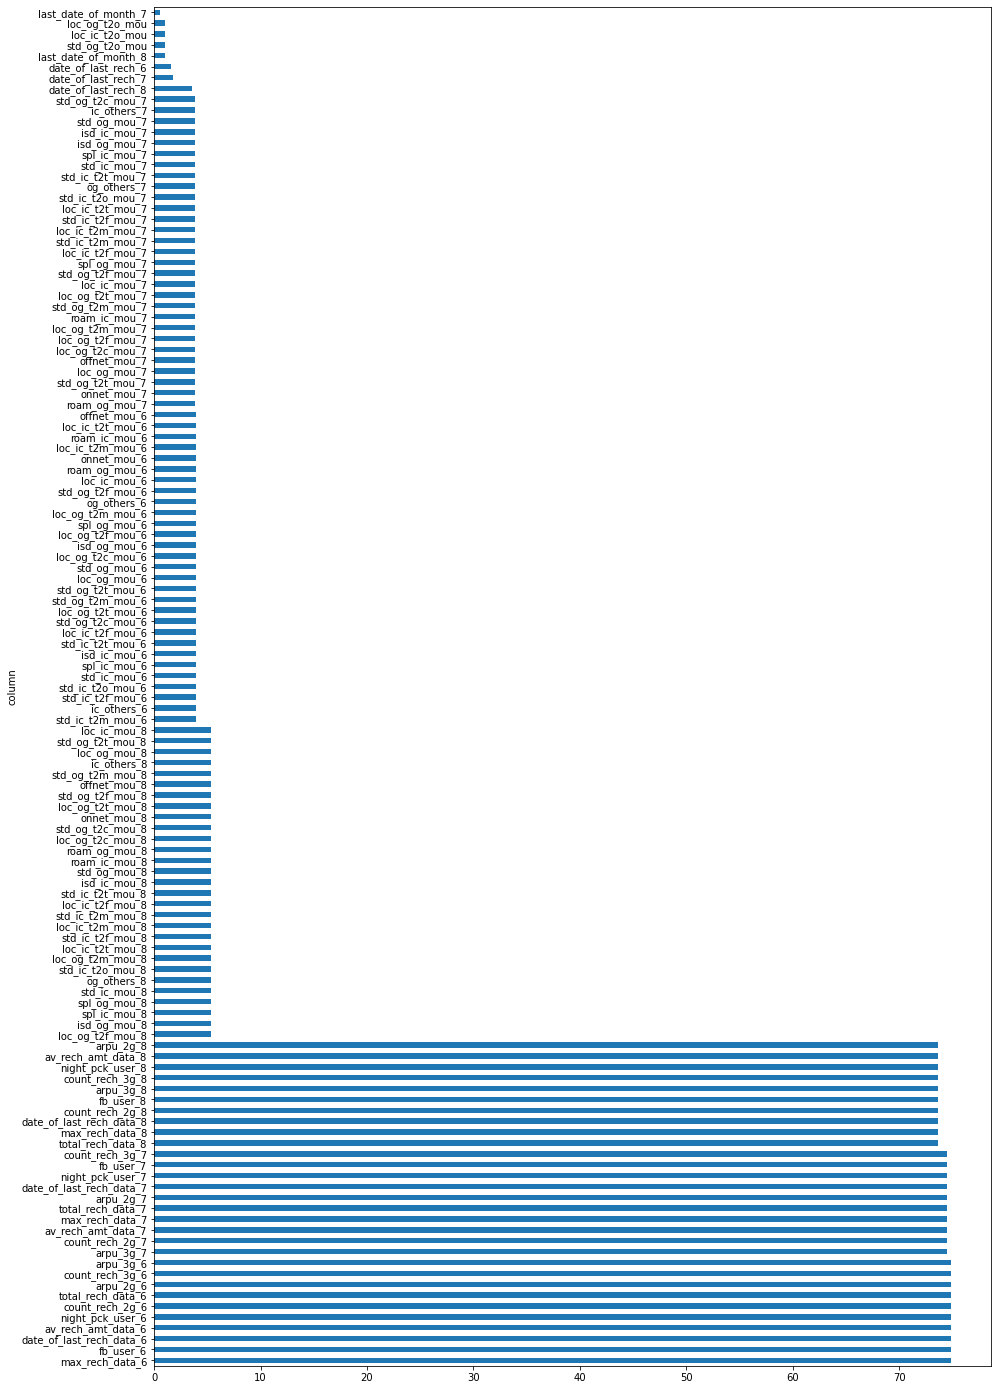

In [8]:
# ii) Identifying Missing Values
# ii-a) We see that 20% of columns having missing values above 70%
plt.figure(figsize=(15,25))
desc[desc.na_perc>0].set_index('column')['na_perc'].sort_values(ascending=False).plot(kind='barh')
plt.show()

In [9]:
# It is also observed that the recharge date and the recharge value are missing together which means 
#the customer didn't recharge
pd.concat([df_train.loc[df_train.total_rech_data_6.isnull() & df_train.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(3),
          df_train.loc[df_train.total_rech_data_7.isnull() & df_train.date_of_last_rech_data_7.isnull(), ["total_rech_data_7", "date_of_last_rech_data_7"]].head(3),
          df_train.loc[df_train.total_rech_data_8.isnull() & df_train.date_of_last_rech_data_8.isnull(), ["total_rech_data_8", "date_of_last_rech_data_8"]].head(3)],axis=1)

,total_rech_data_6,date_of_last_rech_data_6,total_rech_data_7,date_of_last_rech_data_7,total_rech_data_8,date_of_last_rech_data_8
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_train.loc[df_train.total_rech_data_6.isnull() & df_train.total_rech_data_7.isnull() & df_train.total_rech_data_8.isnull(), 
            ["total_rech_data_6","total_rech_data_7","total_rech_data_8"]].head()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
0,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN


In [11]:
df_train.loc[df_train.total_rech_data_6.isnull() | df_train.total_rech_data_7.isnull() | df_train.total_rech_data_8.isnull(), ["total_rech_data_6","total_rech_data_7","total_rech_data_8"] ].head()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
0,NaN,NaN,NaN
1,NaN,1.0,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
5,NaN,NaN,NaN


In [12]:
#Since we saw that there are customers who have actually not used to services as he/she have not recharged 
#Such customers have high propensity to churn
# iii) a) Finding Customers Propensity to Recharge 1-> Will not recharge most probably will churn ; 0.5-> Recharged in one or two months,
# Such customers have moderate chance to churn ; 0.0-> Recharged in all three months , hence lower chance to churn
def propensity_to_rech_data(df):
    potential_churn=[]
    for i,j,k in zip(df.total_rech_data_6.iteritems(),df.total_rech_data_7.iteritems(),df.total_rech_data_8.iteritems()):
        if (pd.isna(i[1])&pd.isna(j[1])&pd.isna(k[1])):
            potential_churn.append(1.0)
        elif (pd.isna(i[1]) | pd.isna(j[1]) | pd.isna(k[1])):
            potential_churn.append(0.5)
        else:
            potential_churn.append(0.0)
    return potential_churn


In [13]:
df_train['customer-propensity-rech-data']=propensity_to_rech_data(df_train)
df_test['customer-propensity-rech-data']=propensity_to_rech_data(df_test)

In [14]:
df_train['customer-propensity-rech-data'].value_counts(normalize=True)

1.0    0.626809
0.5    0.220532
0.0    0.152659
Name: customer-propensity-rech-data, dtype: float64

In [15]:
df_train.drop(["total_rech_data_6","total_rech_data_7","total_rech_data_8"],axis=1,inplace=True)
df_test.drop(["total_rech_data_6","total_rech_data_7","total_rech_data_8"],axis=1,inplace=True)

In [16]:
# iii) b) Finding Customers Propensity to use night pack 1-> Have not used night pack at all ,most probably will churn ;
#0.5-> Have used night packs in one or two months, does not use more often, moderate chance to churn ;
# 0.0-> Is constant user of night packs, low chance to churn

def propensity_use_night_pack(df):
    use_night_pack=[]
    for i,j,k in zip(df.night_pck_user_6.iteritems(),df.night_pck_user_7.iteritems(),df.night_pck_user_8.iteritems()):
        if (pd.isna(i[1])&pd.isna(j[1])&pd.isna(k[1])):
            use_night_pack.append(1.0)
        elif (pd.isna(i[1]) | pd.isna(j[1]) | pd.isna(k[1])):
            use_night_pack.append(0.5)
        else:
            use_night_pack.append(0.0)
    return use_night_pack
# iii) c) Finding Customers Propensity to use social media using network 1-> Have not used network to access face book at all ,most probably will churn ;
#0.5-> Have used face book in once or two months, does not use more often, moderate chance to churn ;
# 0.0-> constant user of face book over network, low chance to churn
def propensity_use_fb(df):
    use_fb=[]
    for i,j,k in zip(df.fb_user_6.iteritems(),df.fb_user_7.iteritems(),df.fb_user_8.iteritems()):
        if (pd.isna(i[1])&pd.isna(j[1])&pd.isna(k[1])):
            use_fb.append(1.0)
        elif (pd.isna(i[1]) | pd.isna(j[1]) | pd.isna(k[1])):
            use_fb.append(0.5)
        else:
            use_fb.append(0.0)
    return use_fb


In [17]:
df_train['customer-propensity-night-pck']=propensity_use_night_pack(df_train)
df_test['customer-propensity-night-pck']=propensity_use_night_pack(df_test)

df_train['customer-propensity-fb']=propensity_use_fb(df_train)
df_test['customer-propensity-fb']=propensity_use_fb(df_test)

In [18]:
df_train['customer-propensity-night-pck'].value_counts(normalize=True)

1.0    0.626809
0.5    0.220532
0.0    0.152659
Name: customer-propensity-night-pck, dtype: float64

In [19]:
df_train.drop(["night_pck_user_6",'night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8'],axis=1,inplace=True)
df_test.drop(["night_pck_user_6",'night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8'],axis=1,inplace=True)

In [20]:
cols_drop=df_train.isna().sum()[(df_train.isna().sum()/df_train.shape[0])>.40].index.tolist()

In [21]:
cols_drop

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [22]:
#Finding maximum recharge by users on an average
#If its 0 , most likely user is churning, but there users who recharge once or more , hence it will help to identify their pattern
def average_max_rech(df):
    
    avg_max_rech=df.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].mean(axis=1).fillna(0)
    return avg_max_rech

In [23]:
df_train['average_max_rech']=average_max_rech(df_train)
df_test['average_max_rech']=average_max_rech(df_test)

In [24]:
#Finding count of recharge over 2G network over months by users on an average
#If its 0 , most likely user is churning, but there users who recharge over 2G once or more , hence it will help to identify their pattern

def average_count_rech_2g(df):
    
    avg_2g_count_rech=df.loc[:,['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8']].mean(axis=1).fillna(0)
    return avg_2g_count_rech

In [25]:
df_train['avg_2g_count_rech']=average_count_rech_2g(df_train)

In [26]:
#Finding count of recharge over 3G network over months by users on an average
#If its 0 , most likely user is churning, but there users who recharge over 2G once or more , hence it will help to identify their pattern

def average_count_rech_3g(df):
    
    avg_3g_count_rech=df.loc[:,['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8']].mean(axis=1).fillna(0)
    return avg_3g_count_rech
df_train['avg_3g_count_rech']=average_count_rech_3g(df_train)

In [27]:
df_test['avg_2g_count_rech']=average_count_rech_2g(df_test)
df_test['avg_3g_count_rech']=average_count_rech_3g(df_test)

In [28]:
#Finding average recharge amount for data over months by users on an average
#If its 0 , most likely user is churning, but there users who recharge over 2G & 3G once or more , hence it will help to identify their pattern

def average_recharge_data_amt(df):
    
    avg_recharge_data_amt=df.loc[:,['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']].mean(axis=1).fillna(0)
    return avg_recharge_data_amt
df_train['avg_recharge_data_amt']=average_recharge_data_amt(df_train)
df_test['avg_recharge_data_amt']=average_recharge_data_amt(df_test)

In [29]:
#Finding average revenue per unit on 2G over months by users on an average
#If its 0 , most likely user is churning, but there users who recharge over 2G  once or more , hence it will help to identify their pattern

def average_arpu_2g(df):
    
    avg_arpu_2g=df.loc[:,['arpu_2g_6','arpu_2g_7','arpu_2g_8']].mean(axis=1).fillna(0)
    return avg_arpu_2g
df_train['arpu_2g']=average_arpu_2g(df_train)
df_test['arpu_2g']=average_arpu_2g(df_test)

In [30]:
#Finding average revenue per unit on 3G over months by users on an average
#If its 0 , most likely user is churning, but there users who recharge over  3G once or more , hence it will help to identify their pattern
def average_arpu_3g(df):
    
    avg_arpu_3g=df.loc[:,['arpu_3g_6','arpu_3g_7','arpu_3g_8']].mean(axis=1).fillna(0)
    return avg_arpu_3g
df_train['arpu_3g']=average_arpu_3g(df_train)
df_test['arpu_3g']=average_arpu_3g(df_test)

In [31]:
df_train.drop(cols_drop,axis=1,inplace=True)
df_test.drop(cols_drop,axis=1,inplace=True)

In [32]:
#Finding Missing Values
cols_eval=df_train.isnull().sum()[(df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)>0].index.tolist()

In [33]:
cols_impute=cols_eval[:-3]
cols_drop=cols_eval[-3:]

In [34]:
pd.concat([df_train.loc[df_train.onnet_mou_6.isnull()|df_train.onnet_mou_7.isnull()|df_train.onnet_mou_8.isnull(),['onnet_mou_6','onnet_mou_7','onnet_mou_8']].head(5),
df_train.loc[df_train.onnet_mou_6.isnull()&df_train.onnet_mou_7.isnull()&df_train.onnet_mou_8.isnull(),['onnet_mou_6','onnet_mou_7','onnet_mou_8']].head(5)],axis=1)

,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_6,onnet_mou_7,onnet_mou_8
26,NaN,2.86,1.75,NaN,NaN,NaN
31,412.71,89.09,NaN,NaN,NaN,NaN
33,NaN,NaN,0.00,NaN,NaN,NaN
37,54.41,NaN,NaN,NaN,NaN,NaN
41,37.75,166.74,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,NaN,NaN,NaN,NaN,NaN
296,NaN,NaN,NaN,NaN,NaN,NaN
423,NaN,NaN,NaN,NaN,NaN,NaN
569,NaN,NaN,NaN,NaN,NaN,NaN


We see cases that there are cases where on network calls are none for all the three months data for user, such user have high potential to churn, but there are certain users who have not used on network calls in certain months, hence it means that these nan's are not missing values, it is rather user have not used the service, hence need to impute them with 0s.

In [35]:
for i in cols_impute:
    df_train[i]=df_train[i].fillna(0)
    df_test[i]=df_test[i].fillna(0)


In [36]:
cols_drop

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [37]:
train=df_train.copy()
test=df_test.copy()

In [38]:
train['date_of_last_rech_6']=pd.to_datetime(train['date_of_last_rech_6'])
test['date_of_last_rech_6']=pd.to_datetime(test['date_of_last_rech_6'])
train['date_of_last_rech_7']=pd.to_datetime(train['date_of_last_rech_7'])
test['date_of_last_rech_7']=pd.to_datetime(test['date_of_last_rech_7'])
train['date_of_last_rech_8']=pd.to_datetime(train['date_of_last_rech_8'])
test['date_of_last_rech_8']=pd.to_datetime(test['date_of_last_rech_8'])

In [39]:
#Finding time elapsed from last recharge
train['days_elapsed_from_last_rech_july_june']=(train['date_of_last_rech_7']-train['date_of_last_rech_6']).dt.days
train['days_elapsed_from_last_rech_aug_july']=(train['date_of_last_rech_8']-train['date_of_last_rech_7']).dt.days
train['days_elapsed_from_last_rech_aug_june']=(train['date_of_last_rech_8']-train['date_of_last_rech_6']).dt.days
test['days_elapsed_from_last_rech_july_june']=(test['date_of_last_rech_7']-test['date_of_last_rech_6']).dt.days
test['days_elapsed_from_last_rech_aug_july']=(test['date_of_last_rech_8']-test['date_of_last_rech_7']).dt.days
test['days_elapsed_from_last_rech_aug_june']=(test['date_of_last_rech_8']-test['date_of_last_rech_6']).dt.days
train['days_elapsed_from_last_rech_july_june']=train['days_elapsed_from_last_rech_july_june'].map(lambda x : 0 if ((x<0)or(x>60)) else x)
train['days_elapsed_from_last_rech_aug_july']=train['days_elapsed_from_last_rech_aug_july'].map(lambda x : 0 if ((x<0)or(x>60)) else x)
test['days_elapsed_from_last_rech_july_june']=test['days_elapsed_from_last_rech_july_june'].map(lambda x : 0 if ((x<0)or(x>60)) else x)
test['days_elapsed_from_last_rech_aug_july']=test['days_elapsed_from_last_rech_aug_july'].map(lambda x : 0 if ((x<0)or(x>60)) else x)
train['days_elapsed_from_last_rech_aug_june']=train['days_elapsed_from_last_rech_aug_june'].map(lambda x : 0 if ((x<0)or(x>60)) else x)
test['days_elapsed_from_last_rech_aug_june']=test['days_elapsed_from_last_rech_aug_june'].map(lambda x : 0 if ((x<0)or(x>60)) else x)

In [40]:
#Calculating average elapsed time from last recharge
train['avg_time_elapsed_from_last_rech']=train.loc[:,['days_elapsed_from_last_rech_aug_june','days_elapsed_from_last_rech_aug_july','days_elapsed_from_last_rech_july_june']].mean(axis=1)
test['avg_time_elapsed_from_last_rech']=test.loc[:,['days_elapsed_from_last_rech_aug_june','days_elapsed_from_last_rech_aug_july','days_elapsed_from_last_rech_july_june']].mean(axis=1)

In [41]:
#
train.drop(cols_drop+['days_elapsed_from_last_rech_aug_june','days_elapsed_from_last_rech_aug_july','days_elapsed_from_last_rech_july_june'],axis=1,inplace=True)
test.drop(cols_drop+['days_elapsed_from_last_rech_aug_june','days_elapsed_from_last_rech_aug_july','days_elapsed_from_last_rech_july_june'],axis=1,inplace=True)

In [42]:
train.shape,test.shape

((69999, 136), (30000, 135))

In [43]:
any(train.isna()),any(test.isna())

(True, True)

In [44]:
train['avg_time_elapsed_from_last_rech']=train['avg_time_elapsed_from_last_rech'].fillna(0)
test['avg_time_elapsed_from_last_rech']=test['avg_time_elapsed_from_last_rech'].fillna(0)

In [45]:
#Basic Descriptive Statistics of all the columns
desc=pd.DataFrame()
for i in train.columns:
    desc=pd.concat([desc,pd.DataFrame(report_analysis(i,train))])

In [46]:
categ_cols=desc[desc['nunique']<10].column.tolist()
date_cols=train.select_dtypes('object').columns.tolist()
num_cols=[i for i in train.columns if i not in categ_cols+date_cols+['id']]

In [47]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array
# cap outliers in the numeric columns
train[num_cols] = train[num_cols].apply(cap_outliers, axis=0)
test[num_cols] = test[num_cols].apply(cap_outliers, axis=0)

### EDA

In [48]:
# lets write a function to plot historgram for some sample columns
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts(normalize=True)
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

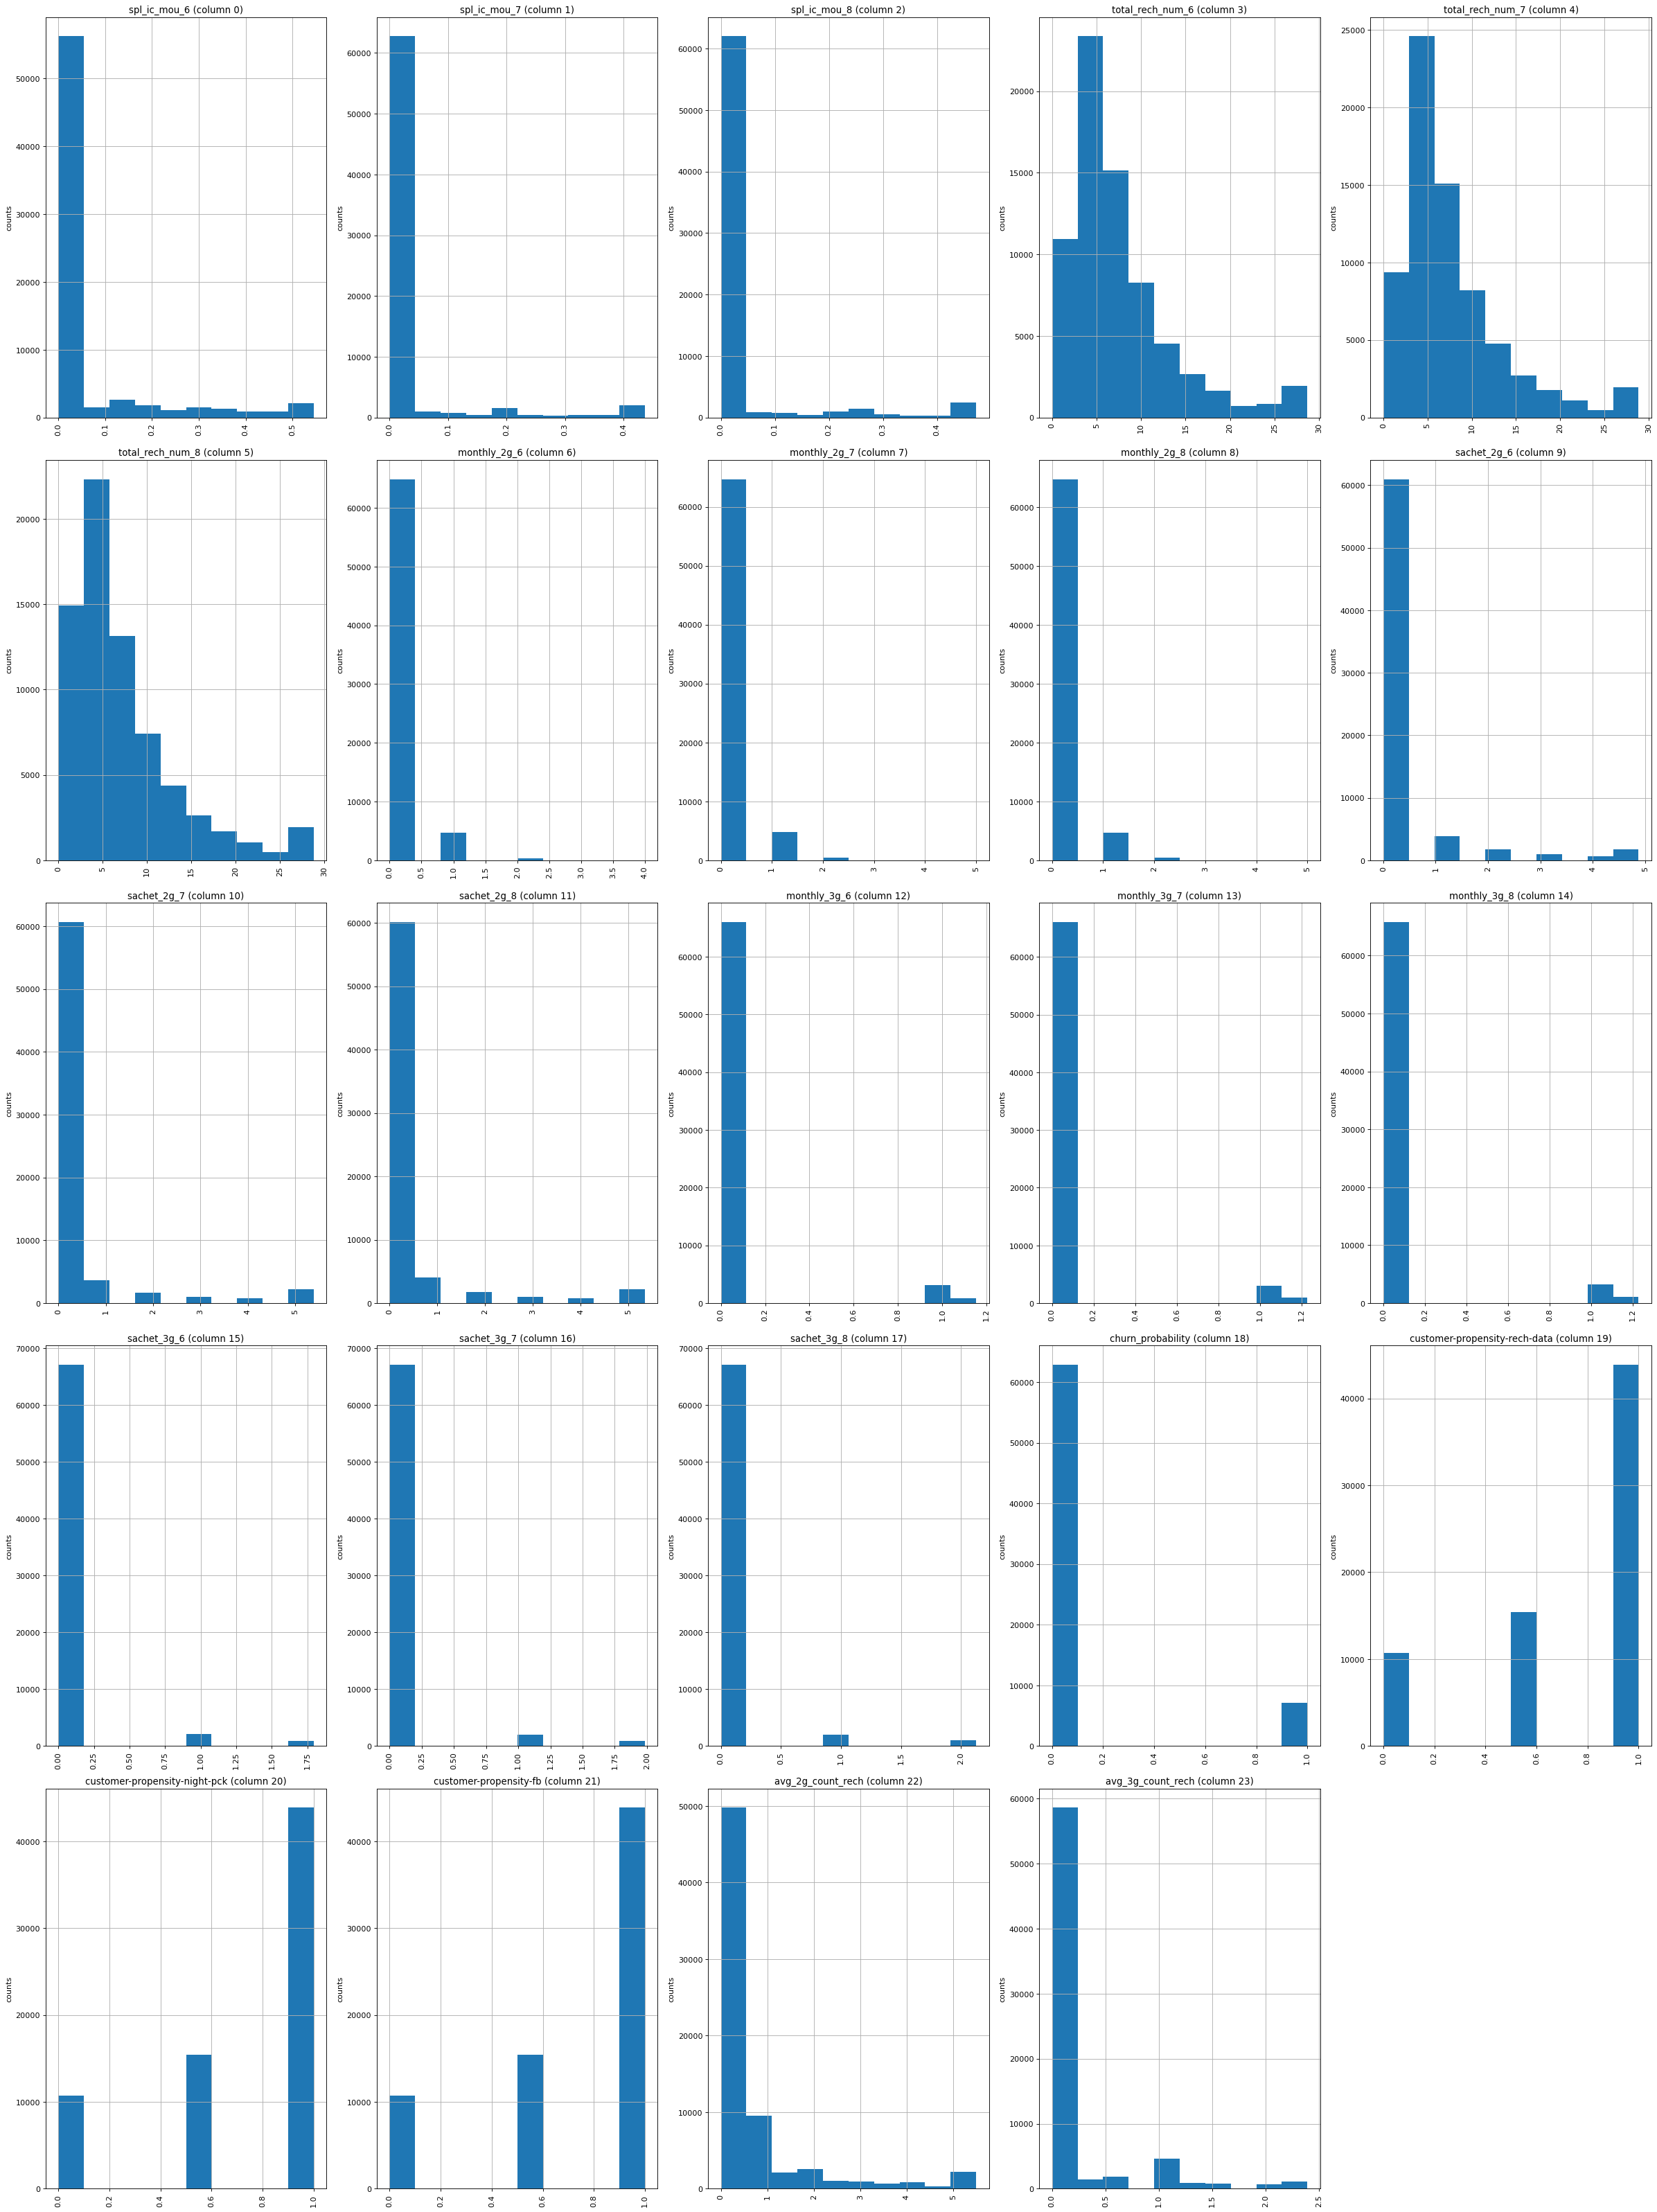

In [49]:
# call the function to plot the graphs
plotPerColumnDistribution(train, 40, 5)

Majority of total recharge done around in between 5-10 times.

Minutes of usage over Special incoming calls during months are generally 0 minutes but when there comes generally is an incomming call , minutes used are mostly 20 seconds

Most customers do not use night packs , face-book or do not recharge data in all these three months - they are around 63% such customers

In [50]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 50]]
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:15]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_4160\710667162.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


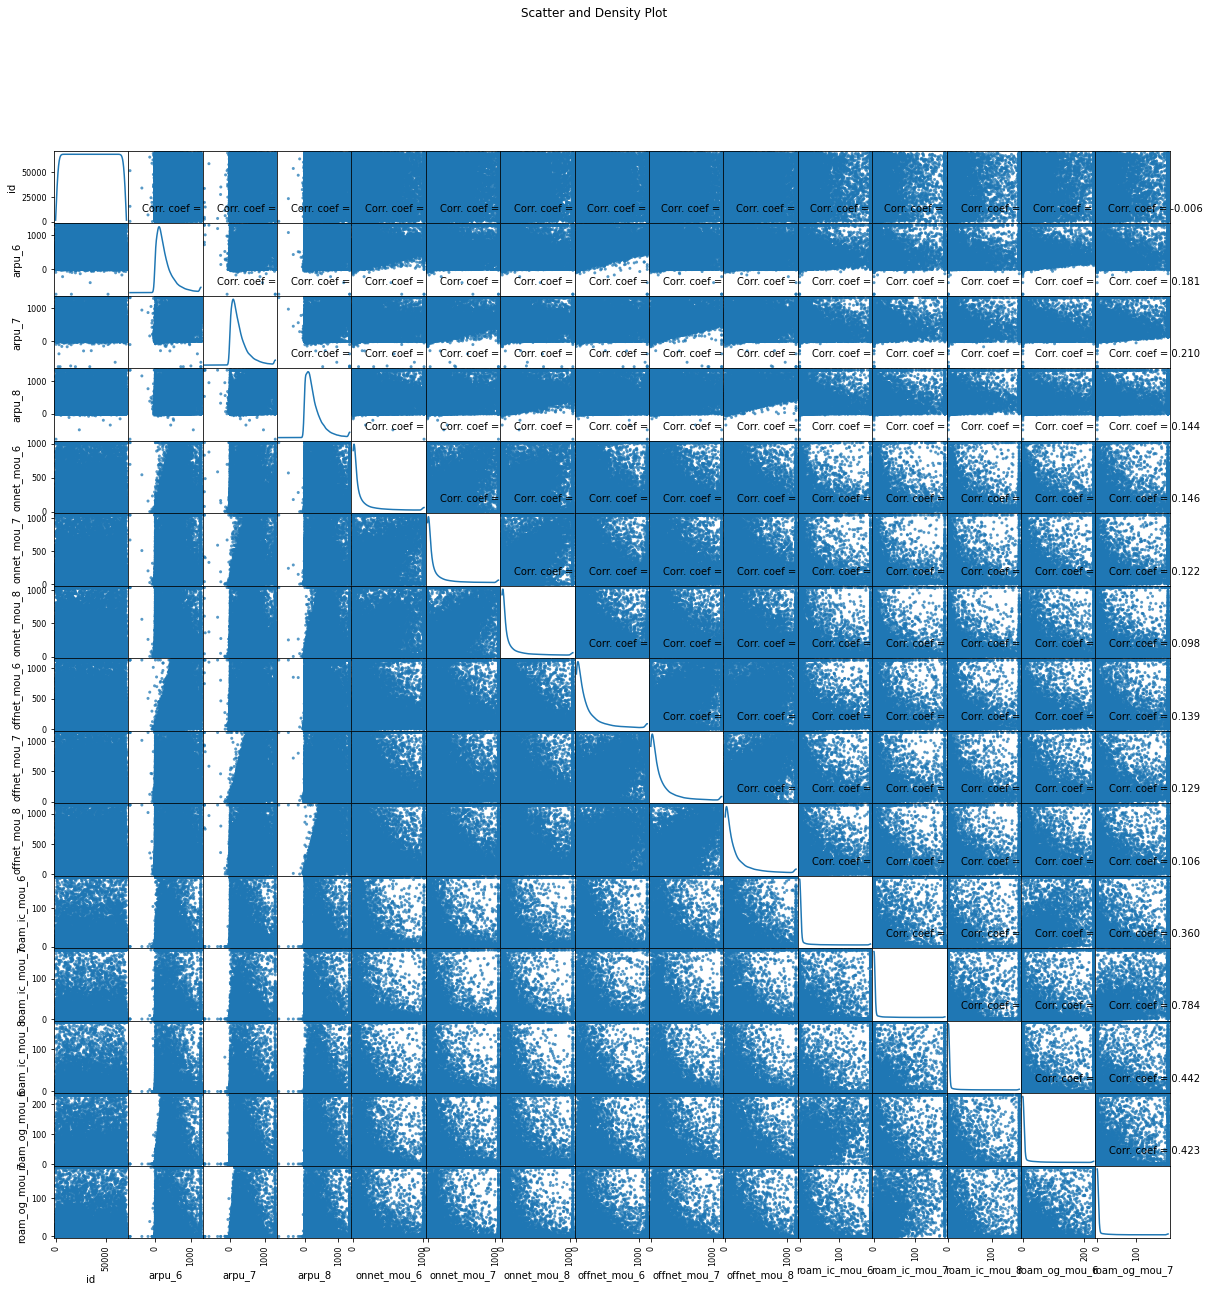

In [51]:
plotScatterMatrix(train, 20, 10)

In [52]:
train.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,customer-propensity-rech-data,customer-propensity-night-pck,customer-propensity-fb,average_max_rech,avg_2g_count_rech,avg_3g_count_rech,avg_recharge_data_amt,arpu_2g,arpu_3g,avg_time_elapsed_from_last_rech
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.000000,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.472416,0.0,0.0,0.0,1.11,0.69,0.00,3.0,2.0,2.0,77.0,65.0,10.0,65.0,65.0,10.0,65.0,65.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1958.0,0.0,0.0,0.0,0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,20.469906,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.010000,0.0,0.0,0.0,0.00,0.00,0.00,3.0,4.0,5.0,0.0,145.0,50.0,0.0,145.0,50.0,0.0,0.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,0,0.5,0.5,0.5,145.000000,0.000000,1.000000,145.000000,122.080000,122.070000,25.000000
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.000000,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.25,2.0,4.0,2.0,70.0,120.0,0.0,70.0,70.0,0.0,70.0,50.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0.0000

In [53]:
contigency_pct = pd.crosstab(train['customer-propensity-rech-data'], train['churn_probability'], normalize='index')

In [54]:
contigency_pct

churn_probability,0,1
customer-propensity-rech-data,,
0.0,0.973797,0.026203
0.5,0.880676,0.119324
1.0,0.885815,0.114185


In [55]:
c, p, dof, expected = chi2_contingency(contigency_pct) 

In [56]:
p

0.9659454019970068

In [57]:
def chi_square_corr(colA,colB='churn_probability',df=train):
    contigency_pct = pd.crosstab(df[colA], df[colB], normalize='index')
    c, p, dof, expected = chi2_contingency(contigency_pct) 
    res=[]
    if p>.95:
        res.append((colA,colB,True))
    else:
        res.append((colA,colB,False))
    return res
    

In [58]:
#Basic Descriptive Statistics of all the columns
desc=pd.DataFrame()
for i in train.columns:
    desc=pd.concat([desc,pd.DataFrame(report_analysis(i,train))])
categ_cols=desc[desc['nunique']<10].column.tolist()
date_cols=train.select_dtypes('object').columns.tolist()
num_cols=[i for i in train.columns if i not in categ_cols+date_cols+['id']]

In [59]:
categ_cols

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'churn_probability',
 'customer-propensity-rech-data',
 'customer-propensity-night-pck',
 'customer-propensity-fb']

In [60]:
chi_results=[]
for i in categ_cols:
    chi_results.append(chi_square_corr(colA=i,colB='churn_probability',df=train))

In [61]:
res=pd.DataFrame()
for i in range(len(chi_results)-1):
    res=pd.concat([res,pd.DataFrame(chi_results[i],columns=['X','y','corr'])],axis=0)

In [62]:
res.reset_index(drop=True,inplace=True)

In [63]:
feature_selected_cat=res[res['corr']==True]['X'].tolist()

In [64]:
def anova(colA,colB='churn_probability',df=train):
    df=df.loc[:,[colA,colB]]
    res=[]
    groups=df.groupby(colB).count().reset_index()
    ratio = df.groupby(colB).std().max() / df.groupby(colB).std().min()
    data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
    anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
    anova_table.set_index('Source of Variation', inplace = True)
    x_bar=df[colA].mean()
    SSTR = df.groupby(colB).count() * (df.groupby(colB).mean() - x_bar)**2
    anova_table['SS']['Between Groups'] = SSTR[colA].sum()
    # calculate SSE and update anova table
    SSE = (df.groupby(colB).count() - 1) * df.groupby(colB).std()**2
    anova_table['SS']['Within Groups'] = SSE[colA].sum()
    # calculate SSTR and update anova table
    SSTR = SSTR[colA].sum() + SSE[colA].sum()
    anova_table['SS']['Total'] = SSTR
    
    # update degree of freedom
    anova_table['df']['Between Groups'] = df[colB].nunique() - 1
    anova_table['df']['Within Groups'] = df.shape[0] - df[colB].nunique()
    anova_table['df']['Total'] = df.shape[0] - 1

    # calculate MS
    anova_table['MS'] = anova_table['SS'] / anova_table['df']

    # calculate F 
    F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
    anova_table['F']['Between Groups'] = F

    # p-value
    anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # F critical 
    alpha = 0.05
    # possible types "right-tailed, left-tailed, two-tailed"
    tail_hypothesis_type = "single-tailed"
    if tail_hypothesis_type == "two-tailed":
        alpha /= 2
    anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])
    #If correlated then True
    conclusion = False
    if anova_table['P-value']['Between Groups'] <= alpha:
        conclusion=True
        res.append((colA,colB,conclusion))
    else:
        res.append((colA,colB,conclusion))
    return pd.DataFrame(res,columns=['X','y','Corr'])
    

   

In [65]:
result=pd.DataFrame()
for i in num_cols:
    print(i)
    result=pd.concat([result,anova(i,'churn_probability',train)])

arpu_6
arpu_7
arpu_8
onnet_mou_6
onnet_mou_7
onnet_mou_8
offnet_mou_6
offnet_mou_7
offnet_mou_8
roam_ic_mou_6
roam_ic_mou_7
roam_ic_mou_8
roam_og_mou_6
roam_og_mou_7
roam_og_mou_8
loc_og_t2t_mou_6
loc_og_t2t_mou_7
loc_og_t2t_mou_8
loc_og_t2m_mou_6
loc_og_t2m_mou_7
loc_og_t2m_mou_8
loc_og_t2f_mou_6
loc_og_t2f_mou_7
loc_og_t2f_mou_8
loc_og_t2c_mou_6
loc_og_t2c_mou_7
loc_og_t2c_mou_8
loc_og_mou_6
loc_og_mou_7
loc_og_mou_8
std_og_t2t_mou_6
std_og_t2t_mou_7
std_og_t2t_mou_8
std_og_t2m_mou_6
std_og_t2m_mou_7
std_og_t2m_mou_8
std_og_t2f_mou_6
std_og_t2f_mou_7
std_og_t2f_mou_8
std_og_mou_6
std_og_mou_7
std_og_mou_8
isd_og_mou_6
isd_og_mou_7
isd_og_mou_8
spl_og_mou_6
spl_og_mou_7
spl_og_mou_8
og_others_6
og_others_7
og_others_8
total_og_mou_6
total_og_mou_7
total_og_mou_8
loc_ic_t2t_mou_6
loc_ic_t2t_mou_7
loc_ic_t2t_mou_8
loc_ic_t2m_mou_6
loc_ic_t2m_mou_7
loc_ic_t2m_mou_8
loc_ic_t2f_mou_6
loc_ic_t2f_mou_7
loc_ic_t2f_mou_8
loc_ic_mou_6
loc_ic_mou_7
loc_ic_mou_8
std_ic_t2t_mou_6
std_ic_t2t_mou_7


In [66]:
result

,X,y,Corr
0,arpu_6,churn_probability,True
0,arpu_7,churn_probability,True
0,arpu_8,churn_probability,True
0,onnet_mou_6,churn_probability,True
0,onnet_mou_7,churn_probability,True
0,onnet_mou_8,churn_probability,True
0,offnet_mou_6,churn_probability,True
0,offnet_mou_7,churn_probability,True
0,offnet_mou_8,churn_probability,True
0,roam_ic_mou_6,churn_probability,True


In [67]:
feature_selected_num=result[result['Corr']==True]['X'].tolist()

In [68]:
final_train=train.loc[:,feature_selected_num+feature_selected_cat]

In [69]:
feature_selected_cat.pop(-3)

'churn_probability'

In [70]:
final_test=test.loc[:,feature_selected_num+feature_selected_cat]

In [71]:
final_train['aon']=round(final_train['aon']/365,1)
final_test['aon']=round(final_test['aon']/365,1)

In [72]:
final_train.shape,final_test.shape

((69999, 125), (30000, 124))

In [77]:
final_train.groupby(['churn_probability']).agg(avg_Tenure=('aon','median'))

,avg_Tenure
churn_probability,
0,2.5
1,1.6


In [78]:
final_train.groupby('churn_probability').agg(Average_June_VBC=('jun_vbc_3g','mean'),variation_June_VBC=('jun_vbc_3g','std'))

,Average_June_VBC,variation_June_VBC
churn_probability,,
0,49.134644,160.167096
1,34.209922,135.189991


In [79]:
final_train.groupby('churn_probability').agg(Average_July_VBC=('jul_vbc_3g','mean'),variation_July_VBC=('jul_vbc_3g','std'))

,Average_July_VBC,variation_July_VBC
churn_probability,,
0,55.752825,174.586072
1,27.263294,122.290840


In [80]:
final_train.groupby('churn_probability').agg(Average_Aug_VBC=('aug_vbc_3g','mean'),variation_Aug_VBC=('aug_vbc_3g','std'))

,Average_Aug_VBC,variation_Aug_VBC
churn_probability,,
0,60.160030,180.279157
1,14.410173,85.709002


In [81]:
final_train.groupby('churn_probability').agg(Average_june_volume3G=('vol_3g_mb_6','mean'),variation_june_volume3G=('vol_3g_mb_6','std'))

,Average_june_volume3G,variation_june_volume3G
churn_probability,,
0,103.195442,327.278279
1,75.385275,287.073872


In [82]:
final_train.groupby('churn_probability').agg(Average_jly_volume3G=('vol_3g_mb_7','mean'),variation_july_volume3G=('vol_3g_mb_7','std'))

,Average_jly_volume3G,variation_july_volume3G
churn_probability,,
0,111.709313,341.409977
1,53.872354,245.536434


In [83]:
final_train.groupby('churn_probability').agg(Average_aug_volume3G=('vol_3g_mb_8','mean'),variation_aug_volume3G=('vol_3g_mb_8','std'))

,Average_aug_volume3G,variation_aug_volume3G
churn_probability,,
0,121.567005,357.304723
1,26.751595,177.421118


In [84]:
final_train.groupby('churn_probability').agg(Average_june_volume2G=('vol_2g_mb_6','mean'),variation_june_volume2G=('vol_2g_mb_6','std'))

,Average_june_volume2G,variation_june_volume2G
churn_probability,,
0,42.420918,133.088976
1,32.948417,118.119669


In [85]:
final_train.groupby('churn_probability').agg(Average_jly_volume2G=('vol_2g_mb_7','mean'),variation_july_volume2G=('vol_2g_mb_7','std'))

,Average_jly_volume2G,variation_july_volume2G
churn_probability,,
0,42.432284,132.335858
1,24.116211,101.460002


In [86]:
final_train.groupby('churn_probability').agg(Average_aug_volume2G=('vol_2g_mb_8','mean'),variation_aug_volume2G=('vol_2g_mb_8','std'))

,Average_aug_volume2G,variation_aug_volume2G
churn_probability,,
0,43.174327,133.393540
1,8.545255,59.973587


In [87]:
final_train.groupby('churn_probability').agg(Average_last_day_rech_6=('last_day_rch_amt_6','mean'),variation_last_day_rech_6=('last_day_rch_amt_6','std'))

,Average_last_day_rech_6,variation_last_day_rech_6
churn_probability,,
0,60.903855,72.038543
1,52.577122,69.468286


In [88]:
final_train.groupby('churn_probability').agg(Average_last_day_rech_7=('last_day_rch_amt_7','mean'),variation_last_day_rech_7=('last_day_rch_amt_7','std'))

,Average_last_day_rech_7,variation_last_day_rech_7
churn_probability,,
0,58.294851,72.191588
1,35.675621,62.888674


In [89]:
final_train.groupby('churn_probability').agg(Average_last_day_rech_8=('last_day_rch_amt_8','mean'),variation_last_day_rech_6=('last_day_rch_amt_8','std'))

,Average_last_day_rech_8,variation_last_day_rech_6
churn_probability,,
0,63.813629,78.239152
1,17.934877,52.338607


In [90]:
final_train.groupby('churn_probability').agg(Average_max_rech_6=('max_rech_amt_6','mean'),variation_max_rech_6=('max_rech_amt_6','std'))

,Average_max_rech_6,variation_max_rech_6
churn_probability,,
0,101.029115,90.337020
1,93.204820,91.360265


In [91]:
final_train.groupby('churn_probability').agg(Average_max_rech_7=('max_rech_amt_7','mean'),variation_max_rech_7=('max_rech_amt_7','std'))

,Average_max_rech_7,variation_max_rech_7
churn_probability,,
0,102.858457,91.043869
1,71.652070,90.910238


In [92]:
final_train.groupby('churn_probability').agg(Average_max_rech_=('max_rech_amt_8','mean'),variation_max_rech_8=('max_rech_amt_8','std'))

,Average_max_rech_,variation_max_rech_8
churn_probability,,
0,109.954583,94.963907
1,44.861359,82.769985


In [93]:
final_train.groupby('churn_probability').agg(Average_ic_others_6=('ic_others_6','mean'),variation_ic_others_6=('ic_others_6','std'))

,Average_ic_others_6,variation_ic_others_6
churn_probability,,
0,0.567941,3.023536
1,0.468112,2.738689


In [94]:
final_train.groupby('churn_probability').agg(Average_ic_others_7=('ic_others_7','mean'),variation_ic_others_7=('ic_others_7','std'))

,Average_ic_others_7,variation_ic_others_7
churn_probability,,
0,0.677349,3.467952
1,0.381016,2.687980


In [95]:

final_train.groupby('churn_probability').agg(Average_ic_others_8=('ic_others_8','mean'),variation_ic_others_8=('ic_others_8','std'))

,Average_ic_others_8,variation_ic_others_8
churn_probability,,
0,0.650231,3.232656
1,0.162752,1.735456


In [96]:
final_train.groupby('churn_probability').agg(Average_total_ic_6=('total_ic_mou_6','mean'),variation_total_ic_6=('total_ic_mou_6','std'))

,Average_total_ic_6,variation_total_ic_6
churn_probability,,
0,196.022548,224.521368
1,127.971648,198.116752


In [97]:
final_train.groupby('churn_probability').agg(Average_total_ic_7=('total_ic_mou_7','mean'),variation_total_ic_7=('total_ic_mou_7','std'))

,Average_total_ic_7,variation_total_ic_7
churn_probability,,
0,202.396815,227.937475
1,89.735888,168.701540


In [98]:
final_train.groupby('churn_probability').agg(Average_total_ic_8=('total_ic_mou_8','mean'),variation_total_ic_8=('total_ic_mou_8','std'))

,Average_total_ic_8,variation_total_ic_8
churn_probability,,
0,205.237884,225.194413
1,36.879474,106.709871


In [99]:
final_train.groupby('churn_probability').agg(Average_total_og_6=('total_og_mou_6','mean'),variation_total_og_6=('total_og_mou_6','std'))

,Average_total_og_6,variation_total_og_6
churn_probability,,
0,286.296454,370.134968
1,324.365917,438.587100


In [100]:
final_train.groupby('churn_probability').agg(Average_total_og_7=('total_og_mou_7','mean'),variation_total_og_7=('total_og_mou_7','std'))

,Average_total_og_7,variation_total_og_7
churn_probability,,
0,301.793520,386.369953
1,223.719656,390.310404


In [101]:
final_train.groupby('churn_probability').agg(Average_total_og_8=('total_og_mou_8','mean'),variation_total_og_8=('total_og_mou_8','std'))

,Average_total_og_8,variation_total_og_8
churn_probability,,
0,310.729300,389.888216
1,87.735642,244.234692


In [102]:
final_train.groupby('churn_probability').agg(Average_onnet_mou_6=('onnet_mou_6','mean'),variation_onnet_mou_6=('onnet_mou_6','std'))

,Average_onnet_mou_6,variation_onnet_mou_6
churn_probability,,
0,111.457059,203.212067
1,143.080468,248.206408


In [103]:
final_train.groupby('churn_probability').agg(Average_onnet_mou_7=('onnet_mou_7','mean'),variation_onnet_mou_7=('onnet_mou_7','std'))

,Average_onnet_mou_7,variation_onnet_mou_7
churn_probability,,
0,116.921616,214.436288
1,99.703864,212.838535


In [104]:
final_train.groupby('churn_probability').agg(Average_onnet_mou_8=('onnet_mou_8','mean'),variation_onnet_mou_8=('onnet_mou_8','std'))

,Average_onnet_mou_8,variation_onnet_mou_8
churn_probability,,
0,120.284972,216.363603
1,43.613151,139.042994


In [105]:
final_train.groupby('churn_probability').agg(Average_offnet_mou_6=('offnet_mou_6','mean'),variation_offnet_mou_6=('offnet_mou_6','std'))

,Average_offnet_mou_6,variation_offnet_mou_6
churn_probability,,
0,177.679688,234.930573
1,187.056130,269.596239


In [106]:
final_train.groupby('churn_probability').agg(Average_offnet_mou_7=('offnet_mou_7','mean'),variation_offnet_mou_7=('offnet_mou_7','std'))

,Average_offnet_mou_7,variation_offnet_mou_7
churn_probability,,
0,182.227101,241.911295
1,131.765344,237.658925


In [107]:
final_train.groupby('churn_probability').agg(Average_offnet_mou_8=('offnet_mou_8','mean'),variation_offnet_mou_8=('offnet_mou_8','std'))

,Average_offnet_mou_8,variation_offnet_mou_8
churn_probability,,
0,187.159994,244.319596
1,59.118811,154.592257


In [108]:
final_train.groupby('churn_probability').agg(Average_arpu_6=('arpu_6','mean'),variation_arpu_6=('arpu_6','std'))

,Average_arpu_6,variation_arpu_6
churn_probability,,
0,273.343592,260.373419
1,294.577166,286.833813


In [109]:
final_train.groupby('churn_probability').agg(Average_arpu_7=('arpu_7','mean'),variation_arpu_7=('arpu_7','std'))

,Average_arpu_7,variation_arpu_7
churn_probability,,
0,277.312325,263.606467
1,211.309721,268.195590


In [110]:
final_train.groupby('churn_probability').agg(Average_arpu_8=('arpu_8','mean'),variation_arpu_6=('arpu_8','std'))

,Average_arpu_8,variation_arpu_6
churn_probability,,
0,289.243463,268.969117
1,110.287119,206.754679


- We notice that customers who churn , their tenure is less than tenure of customers who do not churn

- We notice that those who are likely to churn there average volume based cost decreases over the months , and those who are unlikely to churn their average volume based cost increases

- We see customers who have high tendency to churn their usage of 3g substantially decrease over the months and gap between volume usage of 3g between non churners to churners also increases over month

- We see customers who have high tendency to churn their usage of 2g substantially decrease over the months and gap between volume usage of 2g between non churners to churners also increases over month

- We see customers who have high tendency to churn their recharge on the last day of the month decreases over the months , i.e from June to August. Also we notice that over the months the gap between last recharge of non-churners and churners increases.

- We see customers who have high tendency to churn their maximum recharge over the months decreases , i.e from June to August. Also we notice that over the months the gap between max recharge of non-churners and churners increases.

- We see customers who have high tendency to churn their average incoming on others over the months decreases.

- We see that the customers who are likely to churn their total incoming calls decreases over the months and for non churners it increases.

- We see that the customers who are likely to churn their total outgoing calls decreases over the months and for non churners it increases.

- We see that the customers who are likely to churn their calls within same network decreases over the months and for non churners it remains same.

- We see that the customers who are likely to churn their calls off different network decreases over the months and for non churners it remains same.

- We see that the customers who are likely to churn their average revenue per unit decreases over the months and for non churners it is not much a change

In [111]:
# i) Initial Descriptive Stats of Data
desc=pd.DataFrame()
for i in final_train.columns:
    desc=pd.concat([desc,pd.DataFrame(report_analysis(i,final_train))])

In [112]:
desc[(desc['nunique']<15)].set_index('column').index.tolist()

,nunique,var_contrib,data_type,first_quantile,second_quantile,third_quantile,na_perc,IQR,stdv,mean,median,max,ninty_nine_perc,min
column,,,,,,,,,,,,,,
avg_3g_count_rech,11,0.0,float64,0.0,0.0,0.0,0.0,0.0,0.471552,0.179092,0.0,2.390989,2.391,0.0
monthly_2g_6,5,0.0,int64,0.0,0.0,0.0,0.0,0.0,0.294719,0.079287,0.0,4.000000,1.000,0.0
monthly_2g_7,6,0.0,int64,0.0,0.0,0.0,0.0,0.0,0.304802,0.083401,0.0,5.000000,1.000,0.0
monthly_2g_8,6,0.0,int64,0.0,0.0,0.0,0.0,0.0,0.299254,0.080930,0.0,5.000000,1.000,0.0
sachet_2g_6,6,0.0,float64,0.0,0.0,0.0,0.0,0.0,0.967822,0.307314,0.0,4.871481,4.871,0.0
sachet_2g_7,7,0.0,float64,0.0,0.0,0.0,0.0,0.0,1.103628,0.354889,0.0,5.394443,5.394,0.0
sachet_2g_8,7,0.0,float64,0.0,0.0,0.0,0.0,0.0,1.106312,0.365273,0.0,5.346842,5.347,0.0
monthly_3g_6,3,0.0,float64,0.0,0.0,0.0,0.0,0.0,0.240425,0.059144,0.0,1.152531,1.153,0.0
monthly_3g_7,3,0.0,float64,0.0,0.0,0.0,0.0,0.0,0.244584,0.059436,0.0,1.227297,1.227,0.0


In [115]:
#0->Less Recharge ; 1->More average 3g recharge count ; .5 -> moderate count of 3g recharge count
final_train['avg_3g_count_rech']=pd.cut(final_train['avg_3g_count_rech'],bins=3,labels=[0,.5,1],precision=0)

In [116]:
#0->Less Recharge ; 1->More average 3g recharge count ; .5 -> moderate count of 3g recharge count
final_test['avg_3g_count_rech']=pd.cut(final_test['avg_3g_count_rech'],bins=3,labels=[0,.5,1],precision=0)

In [118]:
#0->No or very less use of 2g in june,0.5->Moderate use of 2g in June , 1-> Max use of 2g In June
final_train['monthly_2g_6']=pd.cut(final_train['monthly_2g_6'],bins=3,labels=[0,.5,1],precision=0)
final_test['monthly_2g_6']=pd.cut(final_test['monthly_2g_6'],bins=3,labels=[0,.5,1],precision=0)

(-0.0, 1.0]    69584
(1.0, 3.0]       389
(3.0, 4.0]        26
Name: monthly_2g_6, dtype: int64